In [2]:
import pandas as pd

intervals= [
    {'lower': 'q_1', 'upper': 'q_99', 'alpha': 0.02},    # 98% PI
    {'lower': 'q_2', 'upper': 'q_97', 'alpha': 0.05}, # 95% PI
    {'lower': 'q_5', 'upper': 'q_95', 'alpha': 0.1},     # 90% PI
    {'lower': 'q_10', 'upper': 'q_90', 'alpha': 0.2},    # 80% PI
    {'lower': 'q_15', 'upper': 'q_85', 'alpha': 0.3},    # 70% PI
    {'lower': 'q_20', 'upper': 'q_80', 'alpha': 0.4},    # 60% PI
    {'lower': 'q_25', 'upper': 'q_75', 'alpha': 0.5},    # 50% PI
    {'lower': 'q_30', 'upper': 'q_70', 'alpha': 0.6},    # 40% PI
    {'lower': 'q_35', 'upper': 'q_65', 'alpha': 0.7},    # 30% PI
    {'lower': 'q_40', 'upper': 'q_60', 'alpha': 0.8},    # 20% PI
    {'lower': 'q_45', 'upper': 'q_55', 'alpha': 0.9}     # 10% PI
]
def create_ensemble_model(models, intervals, input_path_template="../res/{model}/{model}_base_stage_holi_pf_ol_42test.csv",
                         output_path="../res/ensemble_model_with_intervals.csv"):
    # 提取分位数列名
    quantile_columns = list(set([interval['lower'] for interval in intervals] +
                              [interval['upper'] for interval in intervals]))
    required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns

    # 读取并过滤每个模型的数据
    dfs = []
    for model in models:
        file_path = input_path_template.format(model=model)
        df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
        if 'mode' in df.columns:
            df = df[df['mode'] == 'train_seed42'][required_columns]
        else:
            df = df[required_columns]
        df['model'] = model  # 添加模型名称用于追踪
        dfs.append(df)

    # 合并所有数据框
    combined_df = pd.concat(dfs, ignore_index=True)

    # 按 date 和 week_ahead 对齐预测
    pivot_df = combined_df.pivot_table(
        index=['date', 'week_ahead', 'true'],
        columns='model',
        values=['point'] + quantile_columns,
        aggfunc='mean'
    ).reset_index()

    # 展平多级列名
    pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]

    # 计算集成点预测
    pivot_df['point'] = pivot_df[[f'point_{model}' for model in models]].mean(axis=1, skipna=True)

    # 计算集成预测区间，保持原始分位数列名
    for interval in intervals:
        lower_col = interval['lower']
        upper_col = interval['upper']
        pivot_df[lower_col] = pivot_df[[f'{lower_col}_{model}' for model in models]].mean(axis=1, skipna=True)
        pivot_df[upper_col] = pivot_df[[f'{upper_col}_{model}' for model in models]].mean(axis=1, skipna=True)

    # 选择输出列
    output_columns = ['date', 'week_ahead', 'true', 'point'] + \
                     [interval['lower'] for interval in intervals] + \
                     [interval['upper'] for interval in intervals]
    ensemble_df = pivot_df[output_columns]

    # 保存集成结果
    ensemble_df.to_csv(output_path, index=False)

    # 检查缺失预测
    missing_data = pivot_df[[f'point_{model}' for model in models] +
                           [f'{q}_{model}' for q in quantile_columns for model in models]].isna().any(axis=1)
    if missing_data.any():
        print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
        print(pivot_df[missing_data][['date', 'week_ahead']])

    return ensemble_df

ensemble_df = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals,  input_path_template="../res/{model}/{model}_base_week_holi_pf_42test.csv",
                         output_path="../res/ensemble_model_with_intervals.csv")
ensemble_df2 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_week_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base_week.csv")
ensemble_df3 = create_ensemble_model(['itransformer','gru','tcn','Nbeats'],intervals, input_path_template="../res/{model}/{model}_base_42test.csv",
                         output_path="../res/ensemble_model_with_intervals_base.csv")



In [3]:
def create_ensemble_model_from_two_files(file_path1, file_path2, intervals,
                                       output_path="../res/ensemble_model_with_intervals.csv"):
    """
    集成两个模型文件的结果

    参数:
    file_path1: 第一个模型文件路径
    file_path2: 第二个模型文件路径
    intervals: 区间配置列表，如 [{'lower': 'q10', 'upper': 'q90'}, ...]
    output_path: 输出文件路径

    返回:
    集成后的DataFrame
    """
    # 提取分位数列名
    quantile_columns = list(set([interval['lower'] for interval in intervals] +
                              [interval['upper'] for interval in intervals]))
    required_columns = ['point', 'true', 'date', 'week_ahead'] + quantile_columns

    # 读取并过滤两个文件的数据
    dfs = []
    for i, file_path in enumerate([file_path1, file_path2]):
        df = pd.read_csv(file_path)  # 如果文件非 CSV，需调整
        if 'mode' in df.columns:
            df = df[df['mode'] == 'train'][required_columns]
        else:
            df = df[required_columns]
        df['model'] = f'model_{i+1}'  # 添加模型名称用于追踪
        dfs.append(df)

    # 合并所有数据框
    combined_df = pd.concat(dfs, ignore_index=True)

    # 按 date 和 week_ahead 对齐预测
    pivot_df = combined_df.pivot_table(
        index=['date', 'week_ahead', 'true'],
        columns='model',
        values=['point'] + quantile_columns,
        aggfunc='mean'
    ).reset_index()

    # 展平多级列名
    pivot_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in pivot_df.columns]

    # 计算集成点预测
    pivot_df['point'] = pivot_df[['point_model_1', 'point_model_2']].mean(axis=1, skipna=True)

    # 计算集成预测区间，保持原始分位数列名
    for interval in intervals:
        lower_col = interval['lower']
        upper_col = interval['upper']
        pivot_df[lower_col] = pivot_df[[f'{lower_col}_model_1', f'{lower_col}_model_2']].mean(axis=1, skipna=True)
        pivot_df[upper_col] = pivot_df[[f'{upper_col}_model_1', f'{upper_col}_model_2']].mean(axis=1, skipna=True)

    # 选择输出列
    output_columns = ['date', 'week_ahead', 'true', 'point'] + \
                     [interval['lower'] for interval in intervals] + \
                     [interval['upper'] for interval in intervals]
    ensemble_df = pivot_df[output_columns]

    # 保存集成结果
    ensemble_df.to_csv(output_path, index=False)

    # 检查缺失预测
    missing_data = pivot_df[['point_model_1', 'point_model_2'] +
                           [f'{q}_model_1' for q in quantile_columns] +
                           [f'{q}_model_2' for q in quantile_columns]].isna().any(axis=1)
    if missing_data.any():
        print("警告：某些模型在特定 date/week_ahead 组合下缺少预测数据。")
        print(pivot_df[missing_data][['date', 'week_ahead']])

    return ensemble_df

# model_name = 'Nbeats'
# result = create_ensemble_model_from_two_files(
#     file_path1=f"../res/{model_name}/{model_name}_base_pf_42test.csv",
#     file_path2=f"../res/{model_name}/{model_name}_base_week_pf_42test.csv",
#     intervals=intervals,
#     output_path="ensemble_results_pf.csv"
# )

# result1 = create_ensemble_model_from_two_files(
#   file_path1=f"../res/{model_name}/{model_name}_base_42test.csv",
#     file_path2=f"../res/{model_name}/{model_name}_base_week_42test.csv",
#     intervals=intervals,
#     output_path="ensemble_results.csv"
# )

In [4]:

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # 避免分母为 0（如果 y_true + y_pred = 0，替换成很小的数）
    denominator = (np.abs(y_true) + np.abs(y_pred))
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return np.mean(np.abs(y_pred - y_true) / denominator) * 100  # 百分比形式

def interval_score(y, lower, upper, alpha):
    width = upper - lower
    penalty_lower = (2 / alpha) * (lower - y) * (y < lower)
    penalty_upper = (2 / alpha) * (y - upper) * (y > upper)
    return width + penalty_lower + penalty_upper

def calculate_coverate(t,rate='95'):
    intervals = {
              "95":  {'lower': 'q_2', 'upper': 'q_97'},  # 95%
              "80":   {'lower': 'q_10', 'upper': 'q_90'},     # 80%
              "50":   {'lower': 'q_25', 'upper': 'q_75'},     # 50%
    }
    interval = intervals[rate]

    y = t['true']
    metrics = {}
    lower = t[interval['lower']] if interval['lower'] else -np.inf
    upper = t[interval['upper']] if interval['upper'] else np.inf
    correct = (y >= lower) & (y <= upper)
    coverate = np.mean(correct)
    return coverate

def calculate_wis(row):
    y = row['true']
    median = y
    K = len(intervals)  # 区间数量

    # 计算所有区间的 IS
    interval_scores = sum(
        0.5 * interval['alpha'] *interval_score(y, row[interval['lower']], row[interval['upper']], interval['alpha'])
        for interval in intervals
    )

    # 中位数误差
    median_penalty = 0.5 * abs(y - median)

    # WIS
    wis = (interval_scores + median_penalty) / (K + 0.5)
    return wis

def median_absolute_error(y_true, y_pred):
    absolute_errors = np.abs(y_true - y_pred)
    return np.median(absolute_errors)

def calculate_accuracy_with_tolerance(true_values, pred_values, tolerance=0.25):
    lower_bound = true_values * (1 - tolerance)
    upper_bound = true_values * (1 + tolerance)
    correct = (pred_values >= lower_bound) & (pred_values <= upper_bound)
    accuracy = np.mean(correct)
    return accuracy

constant
-------------------------------------
ensemble
-------------------------------------
ensemble_base
-------------------------------------
ensemble_base_week
-------------------------------------
0.47253426167885987
0.33658771084891853
0.3118177282813755
0.39364375582483907


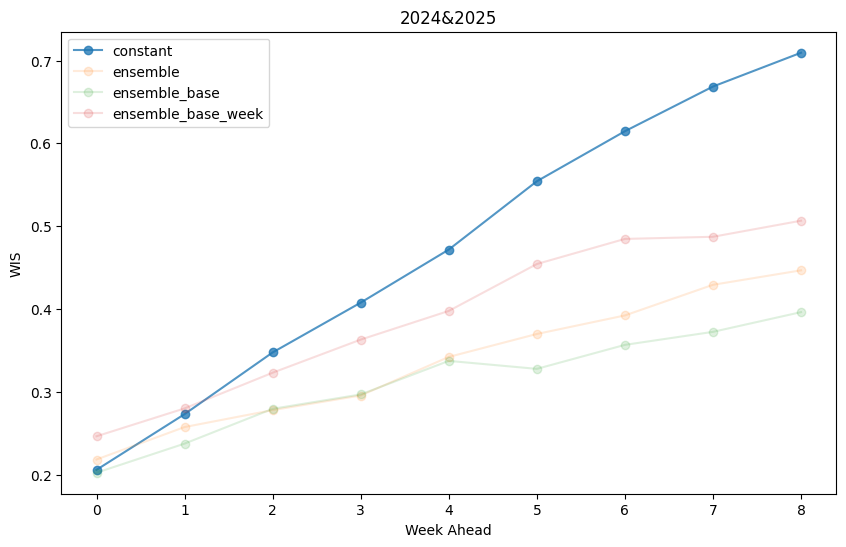

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error

import numpy  as np
# 读取所有模型的预测结果'GRU','TCN','itransformer','Nbeats','ensemble_model''ensemble_model_ol','ensemble_model_no_ol'

def smape_score(y_true, y_pred):
    return  np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
pred_steps=9
model_name = 'tcn'
models = ['constant','ensemble','ensemble_base','ensemble_base_week']

# models = ['constant','gru_base_week_holi_pf','tcn_base_week_holi_pf','Nbeats_base_week_holi_pf','itransformer_base_week_holi_pf','ensemble']

seed = 42
original_method_res = []
for model in models:
    # 构建文件路径
    if model == 'constant':
        path = '../res/forc_baseline.csv'
    elif model ==f'{model_name}_base':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week_holi_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model =='ensemble':
        path ="../res/ensemble_model_with_intervals.csv"
    elif model =='ensemble_base_week':
        path ="../res/ensemble_model_with_intervals_base_week.csv"
    elif model =='ensemble_base':
        path ="../res/ensemble_model_with_intervals_base.csv"
    elif model =='itransformer_base_week_holi_pf':
        path =f'../res/itransformer/{model}_42test.csv'
    elif model =='gru_base_week_holi_pf':
        path =f'../res/gru/{model}_42test.csv'
    elif model =='tcn_base_week_holi_pf':
        path =f'../res/tcn/{model}_42test.csv'
    elif model =='Nbeats_base_week_holi_pf':
        path =f'../res/Nbeats/{model}_42test.csv'
   
    else:
        path=None



    # 读取数据并过滤日期
    res = pd.read_csv(path)
    if 'mode' in res.columns:
        res = res[(res['mode']=='train_seed42')|(res['mode']=='train')]
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - (res['week_ahead'])*timedelta(days=7)
    # Find date_origins where true < 1
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 0.2).any())['date'].unique()
    # invalid_dates = [invalid_date+timedelta(days=7) for invalid_date in invalid_dates]
    # Filter out those date_origins
    res = res[~res['date_origin'].isin(invalid_dates)]
    res = res[(res['date_origin'] >= '2023-09-24')]
    res = res[(res['date_origin'] >= '2024-02-11')]

    # res = res[(res['date_origin'] < '2024-10-06')]
    # res = res[(res['date_origin'] < '2025-05-11')]
    res = res.dropna()
    # 计算每个预测周期的RMSE
    model_rmse = []
    print(model)
    print('-------------------------------------')
    for i in range(pred_steps):
        t = res[res['week_ahead']==i]
        wis = t.apply(calculate_wis, axis=1)
        median_ae = median_absolute_error(t['true'], t['point'])
        wis_mean = np.mean(wis)
        rmse = np.sqrt(mean_squared_error(t['true'], t['point']))
        error_std = np.std(t['true']-t['point'])
        mae = mean_absolute_error(t['true'], t['point'])
        mape = mean_absolute_percentage_error(t['true'], t['point'])
        cov_95 = calculate_coverate(t,rate='95')
        accu = calculate_accuracy_with_tolerance(t['true'], t['point'],tolerance=0.50)
        smape = symmetric_mean_absolute_percentage_error(t['true'], t['point'])
        if model == 'baseline':
            print('RMSE for step %d: %f' % (i, rmse))
        model_rmse.append(wis_mean)
    original_method_res.append(model_rmse)

a = np.mean(original_method_res[0])
b = np.mean(original_method_res[-1])

for k in original_method_res:
    print(np.mean(k))
# 绘图
weeks = range(pred_steps)
plt.figure(figsize=(10, 6))

labels = models
alphas = [0.77,0.15,0.15,0.15,0.15,0.8,1,0.15,1,0.15,1,0.15]

for res, label, alpha in zip(original_method_res, labels, alphas):
    plt.plot(weeks, res, marker='o', label=label, alpha=alpha)

plt.xlabel('Week Ahead')
plt.ylabel('WIS')
plt.title('2024&2025')
plt.legend()
plt.savefig('Japan_res.pdf', dpi=300, bbox_inches='tight')  # 保存为 PNG
plt.show()
# 0.6798692810457516 0.4683277724355507 0.311150267423195
# 0.6798692810457516
# 0.5079241532869191
# 0.4683277724355507
# 2.62

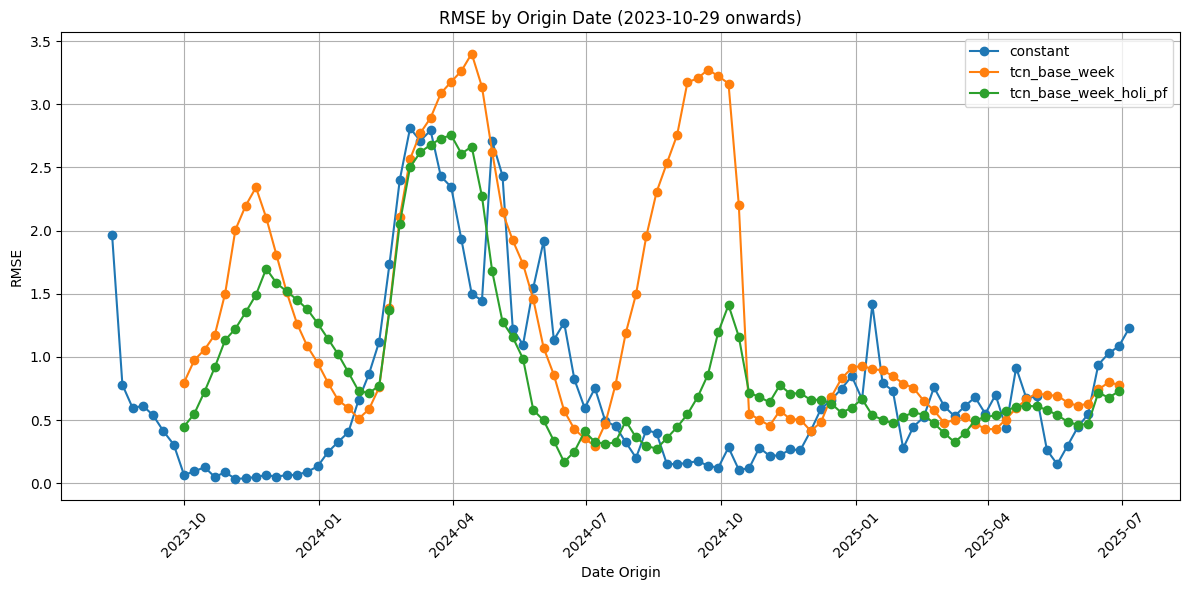

In [7]:
# 读取所有模型的预测结果
model_name = 'tcn'
models = ['constant',f'{model_name}_base_week',f'{model_name}_base_week_holi_pf']
original_method_res = []
pred_steps = pred_steps

plt.figure(figsize=(12, 6))
for model in models:
    # 构建文件路径
    if model == 'constant':
        path = '../res/forc_baseline.csv'
    elif model == 'ensemble_model_ol':
        path = f'../res/ensemble_model_with_intervals.csv'
    elif model == 'ensemble_model_no_ol':
        path = f'../res/ensemble_model_with_intervals_no_ol.csv'
    elif model == 'avg':
        path = f'../res/ensemble_model.csv'
    elif model ==f'{model_name}_base':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model ==f'{model_name}_base_week_holi_pf':
        path =f'../res/{model_name}/{model}_42test.csv'
    elif model =='ensemble':
        path =f'ensemble_results.csv'
    elif model =='ensemble_pf':
        path =f'ensemble_results_pf.csv'
    else:
        path=None

    # 读取数据
    res = pd.read_csv(path)
    if 'mode' in res.columns:
        res = res[(res['mode']=='train_seed42')|(res['mode']=='train')]
    res['date'] = pd.to_datetime(res['date'])
    res['date_origin'] = res['date'] - res['week_ahead'] * timedelta(days=7)
    res = res[(res['date_origin'] > '2023-08-06')]
    invalid_dates = res.groupby('date').filter(lambda x: (x['true'] <= 0.25).any())['date'].unique()
    # Filter out those date_origins
    # res = res[~res['date_origin'].isin(invalid_dates)]
    # res = res[~((res['date_origin'] > '2024-09-01')&(res['date_origin'] < '2024-11-01'))]
    res = res.dropna()
    # res = res[res['week_ahead']<4]
    # 按date_origin分组计算RMSE1
    rmse_by_date = res.groupby('date_origin').apply(
        lambda x: np.sqrt(mean_squared_error(x['true'], x['point']))
    ).reset_index(name='RMSE')

    # 绘制曲线
    plt.plot(rmse_by_date['date_origin'], rmse_by_date['RMSE'],
             marker='o', linestyle='-', label=model)

plt.xlabel('Date Origin')
plt.ylabel('RMSE')
plt.title('RMSE by Origin Date (2023-10-29 onwards)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()